# Tutorial 3: Architecture appearance generation by GANs

In [5]:
from pathlib import Path
from PIL import Image
import cv2

import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image, make_grid
import torchvision.transforms as transforms
from tqdm.notebook import tqdm

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML, display, clear_output
import seaborn as sns
%matplotlib inline

sns.set(style="whitegrid", font_scale=1.2)

In [4]:
pip install opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ---------------------------------------- 0.0/46.2 MB ? eta -:--:--
   ---- ----------------------------------- 5.0/46.2 MB 25.2 MB/s eta 0:00:02
   --------- ------------------------------ 11.5/46.2 MB 27.8 MB/s eta 0:00:02
   -------------- ------------------------- 16.8/46.2 MB 26.4 MB/s eta 0:00:02
   ------------------ --------------------- 21.0/46.2 MB 25.0 MB/s eta 0:00:02
   ---------------------- ----------------- 25.4/46.2 MB 24.4 MB/s eta 0:00:01
   ------------------------- -------------- 29.1/46.2 MB 23.4 MB/s eta 0:00:01
   ---------------------------- ----------- 33.0/46.2 MB 22.6 MB/s eta 0:00:01
   -------------------------------- ------- 37.7/46.2 MB 22.4 MB/s eta 0:00:01
   ----------------------------------- ---- 40.6/46.2 MB 21.7 MB/s eta 0:00:01
   -------------------------------------- - 44.0/46.2 MB 21.2 MB/s eta 0:00:01
   ---------------------------------------- 46.2/46.2 MB 21.1 MB/s e

In [3]:
!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [31]:
from torchsummary import summary

Определим доступность графического процессора

In [29]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

# Подготовка данных

In [13]:
directories = [
    Path("./data/arch/Achaemenid architecture"),
    Path("./data/arch/American craftsman style"),
]

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 64

# Spatial size of training images. All images will be resized to this size using a transformer.
image_size = 128

# Size of z latent vector (i.e. size of generator input)
latent_size = 100

In [14]:
path_files = []

for path in directories:
    files_jpg = list(path.rglob("*.jpg"))
    files_JPG = list(path.rglob("*.JPG"))

    for file in files_jpg:
        path_files.append(file)
        
    for file in files_JPG:
        path_files.append(file)
    
print(len(path_files))

528


In [15]:
class ArchitectureDataset(Dataset):
    
    
    def __init__(self, files):
        super().__init__()
        self.files = sorted(files)
        self.len_ = len(self.files)
        
    
    def __len__(self):
        return self.len_
    
    
    def load_sample(self, file):
        image = cv2.imread(str(file))
        return image
    
    
    def resize_image(self, image, image_height, image_width):
        aspect = image.shape[1] / float(image.shape[0])
        # If the width of the image is greater than the height
        if aspect > 1:
            res = int(aspect * image_height)
            res_image = cv2.resize(image, (res, image_width))
        # If the height of the image is greater than the width
        if aspect < 1:
            res = int(image_width / aspect)
            res_image = cv2.resize(image, (image_height, res))
        if aspect == 1:
            res_image = cv2.resize(image, (image_height, image_width))
        return res_image
        
    
    def center_crop_image(self, image, cropx, cropy):
        y, x, c = image.shape
        startx = x // 2 - (cropx // 2)
        starty = y // 2 - (cropy // 2)
        return image[starty : starty + cropy, startx : startx + cropx]
    
    
    def __getitem__(self, index):
        augmentation = transforms.RandomChoice([
            transforms.RandomHorizontalFlip(p=1),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
        ])
        transform = transforms.Compose([
            augmentation,
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
        ])
        image = self.load_sample(self.files[index])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.resize_image(image, image_size, image_size)
        image = self.center_crop_image(image, image_size, image_size)
        image = Image.fromarray(image)
        image = transform(image)
        
        return image

In [20]:
dataset = ArchitectureDataset(path_files)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [21]:
def denorm(image_tensor):
    mean = 0.5
    std = 0.5
    return image_tensor * std + mean

In [22]:
def show_images(images, n=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    plt.axis("off")
    plt.grid(False)
    ax.imshow(make_grid(denorm(images.detach().cpu()[:n]), nrow=8).permute(1, 2, 0))

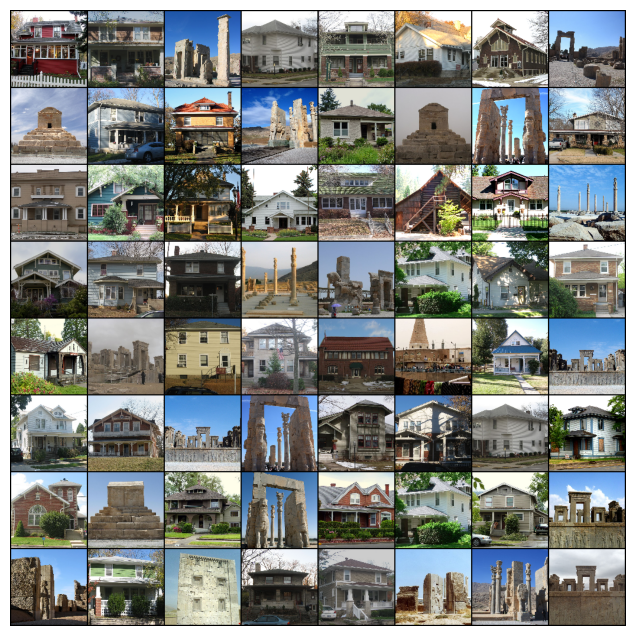

In [23]:
show_images(next(iter(dataloader)), n=64)

In [24]:
image = dataset[1]
print(image.shape)
print(torch.min(image), torch.max(image))

torch.Size([3, 128, 128])
tensor(-0.9922) tensor(1.)


In [25]:
image_batch = next(iter(dataloader))
print(image_batch.shape)

torch.Size([64, 3, 128, 128])


# Построение и обучение модели

- Дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

- Генератор принимает тезор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [26]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [27]:
class Discriminator(nn.Module):
    
    
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.discriminator = nn.Sequential(
            # in: 3 x 128 x 128
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # in: 64 x 64 x 64
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # in: 128 x 32 x 32
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            # in: 256 x 16 x 16
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            # in: 512 x 16 x 16
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True),

            # in: 1024 x 8 x 8
            nn.Flatten(),
            
            nn.Linear(1024 * 8 * 8, 1),
            
            nn.Sigmoid()
        )
        
        
    def forward(self, x):
        return self.discriminator(x)
    

In [32]:
discriminator = Discriminator().to(device)

discriminator.apply(weights_init)

summary(discriminator, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           3,072
         LeakyReLU-2           [-1, 64, 64, 64]               0
            Conv2d-3          [-1, 128, 32, 32]         131,072
       BatchNorm2d-4          [-1, 128, 32, 32]             256
         LeakyReLU-5          [-1, 128, 32, 32]               0
            Conv2d-6          [-1, 256, 16, 16]         524,288
       BatchNorm2d-7          [-1, 256, 16, 16]             512
         LeakyReLU-8          [-1, 256, 16, 16]               0
            Conv2d-9          [-1, 512, 16, 16]       1,179,648
      BatchNorm2d-10          [-1, 512, 16, 16]           1,024
        LeakyReLU-11          [-1, 512, 16, 16]               0
           Conv2d-12           [-1, 1024, 8, 8]       8,388,608
      BatchNorm2d-13           [-1, 1024, 8, 8]           2,048
        LeakyReLU-14           [-1, 102

In [33]:
class Generator(nn.Module):
    
    
    def __init__(self):
        super(Generator, self).__init__()
        
        self.generator = nn.Sequential(
            # in: latent_size x 1 x 1
            nn.Linear(latent_size, 1024 * 8 * 8),
            nn.Unflatten(dim=1, unflattened_size=(1024, 8, 8)),
            nn.LeakyReLU(0.2, inplace=True),
            
            # in: 1024 x 8 x 8          
            nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            # in: 512 x 16 x 16
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            # in: 256 x 32 x 32
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # in: 128 x 64 x 64
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            # in: 64 x 128 x 128
            nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=3, stride=1, padding=1, bias=False),

            # in: 3 x 128 x 128
            nn.Tanh()
        )
        
        
    def forward(self, x):
        return self.generator(x.squeeze())

In [34]:
generator = Generator().to(device)

generator.apply(weights_init)

summary(generator, (100, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 65536]       6,619,136
         Unflatten-2           [-1, 1024, 8, 8]               0
         LeakyReLU-3           [-1, 1024, 8, 8]               0
   ConvTranspose2d-4          [-1, 512, 16, 16]       8,388,608
       BatchNorm2d-5          [-1, 512, 16, 16]           1,024
         LeakyReLU-6          [-1, 512, 16, 16]               0
   ConvTranspose2d-7          [-1, 256, 32, 32]       2,097,152
       BatchNorm2d-8          [-1, 256, 32, 32]             512
         LeakyReLU-9          [-1, 256, 32, 32]               0
  ConvTranspose2d-10          [-1, 128, 64, 64]         524,288
      BatchNorm2d-11          [-1, 128, 64, 64]             256
        LeakyReLU-12          [-1, 128, 64, 64]               0
  ConvTranspose2d-13         [-1, 64, 128, 128]         131,072
      BatchNorm2d-14         [-1, 64, 1

torch.Size([64, 3, 128, 128])


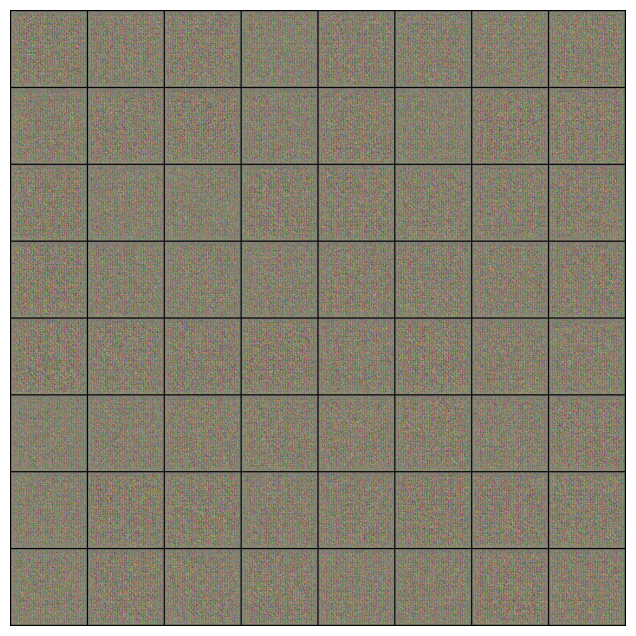

In [35]:
z = torch.randn(64, latent_size, 1, 1, device=device)
fake_images = generator(z)
print(fake_images.shape)

show_images(fake_images, n=64)

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:

1. Учим дискриминатор:

- берем реальные изображения и присваиваем им метку 1
- генерируем изображения генератором и присваиваем им метку 0
- обучаем классификатор на два класса

2. Учим генератор:

- генерируем изображения генератором и присваиваем им метку 0
- предсказываем дискриминаторором, реальное это изображение или нет

В качестве функции потерь берем бинарную кросс-энтропию

При обучении дискриминатора добавим к меткам классов шум ([GAN hacks](https://github.com/soumith/ganhacks))

In [41]:
from typing import List, Optional, Sequence, Tuple

Series = Tuple[Sequence[float], str]

In [43]:

class TrainDCGAN:
    
    
    def __init__(
        self,
        n_epochs: int,
        generator: nn.Module,
        discriminator: nn.Module,
        criterion_generator,
        criterion_discriminator,
        optimizer_generator: optim.Optimizer,
        optimizer_discriminator: optim.Optimizer,
        alpha: float = 0.2,
        verbose: bool = True
    ):
        self.n_epochs = n_epochs
        self.generator = generator
        self.discriminator = discriminator
        self.criterion_generator = criterion_generator
        self.criterion_discriminator = criterion_discriminator
        self.optimizer_generator = optimizer_generator
        self.optimizer_discriminator = optimizer_discriminator
        self.alpha = alpha
        self.verbose = verbose
        
        
    def train(self, dataloader: DataLoader) -> Tuple[list, list, list, list]:
        losses_g = []
        losses_d = []
        real_scores = []
        fake_scores = []
        
        self.discriminator.train()
        self.generator.train()
        torch.cuda.empty_cache()

        for epoch in range(self.n_epochs):
            loss_d_per_epoch = []
            loss_g_per_epoch = []
            real_score_per_epoch = []
            fake_score_per_epoch = []

            for i, real_images in enumerate(tqdm(dataloader)):
                real_images = real_images.to(device)

                # Train discriminator
                self.optimizer_discriminator.zero_grad()

                # Pass real images through discriminator
                real_preds = self.discriminator(real_images)
                noise = torch.rand(real_images.size(0), 1).to(device) * (-alpha)
                real_targets = torch.ones(real_images.size(0), 1, device=device) + noise
                real_loss = self.criterion_discriminator(real_preds, real_targets)
                cur_real_score = torch.mean(real_preds).item()

                # Generate fake images
                latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
                fake_images = self.generator(latent)

                # Pass fake images through discriminator
                noise = torch.rand(fake_images.size(0), 1).to(device) * alpha
                fake_targets = torch.zeros(fake_images.size(0), 1, device=device) + noise
                fake_preds = self.discriminator(fake_images)
                fake_loss = self.criterion_discriminator(fake_preds, fake_targets)
                cur_fake_score = torch.mean(fake_preds).item()

                real_score_per_epoch.append(cur_real_score)
                fake_score_per_epoch.append(cur_fake_score)

                # Update discriminator weights
                loss_d = real_loss + fake_loss
                loss_d.backward()
                self.optimizer_discriminator.step()
                loss_d_per_epoch.append(loss_d.item())

                # Train generator
                self.optimizer_generator.zero_grad()

                # Generate fake images
                latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
                fake_images = self.generator(latent)

                # Try to fool the discriminator
                preds = self.discriminator(fake_images)
                targets = torch.ones(batch_size, 1, device=device)
                loss_g = self.criterion_generator(preds, targets)

                # Update generator weights
                loss_g.backward()
                self.optimizer_generator.step()
                loss_g_per_epoch.append(loss_g.item())

            # Record losses and scores
            losses_g.append(np.mean(loss_g_per_epoch))
            losses_d.append(np.mean(loss_d_per_epoch))
            real_scores.append(np.mean(real_score_per_epoch))
            fake_scores.append(np.mean(fake_score_per_epoch))
            
            if self.verbose:
                clear_output(wait=True)
                self.show_train_process(
                    losses = [(losses_g, "generator loss"), (losses_d, "discriminator loss")],
                    title = f"Epoch {epoch}: generator loss -> {losses_g[-1]:.4f}, discriminator loss -> {losses_d[-1]:.4f}"
                )

            # Log losses and scores (last batch)
            print(f"Epoch [{epoch + 1}/{self.n_epochs}], loss_g: {losses_g[-1]:.4f}, loss_d: {losses_d[-1]:.4f},",
                  f"real_score: {real_scores[-1]:.4f}, fake_score: {fake_scores[-1]:.4f}", sep=" ")

        return losses_g, losses_d, real_scores, fake_scores
    
    
    def show_train_process(
        self,
        losses: Sequence[Series],
        title: Optional[str] = None,
    ):
        plt.figure(figsize=(15, 7))

        for loss, label in losses:
            plt.plot(loss, label=label)

        if title is not None:
            plt.title(title)

        plt.xlabel("epochs")
        plt.ylabel("loss")
        plt.xticks(np.arange(0, len(losses[0][0]) + 1, 10))
        plt.legend()
        plt.show()

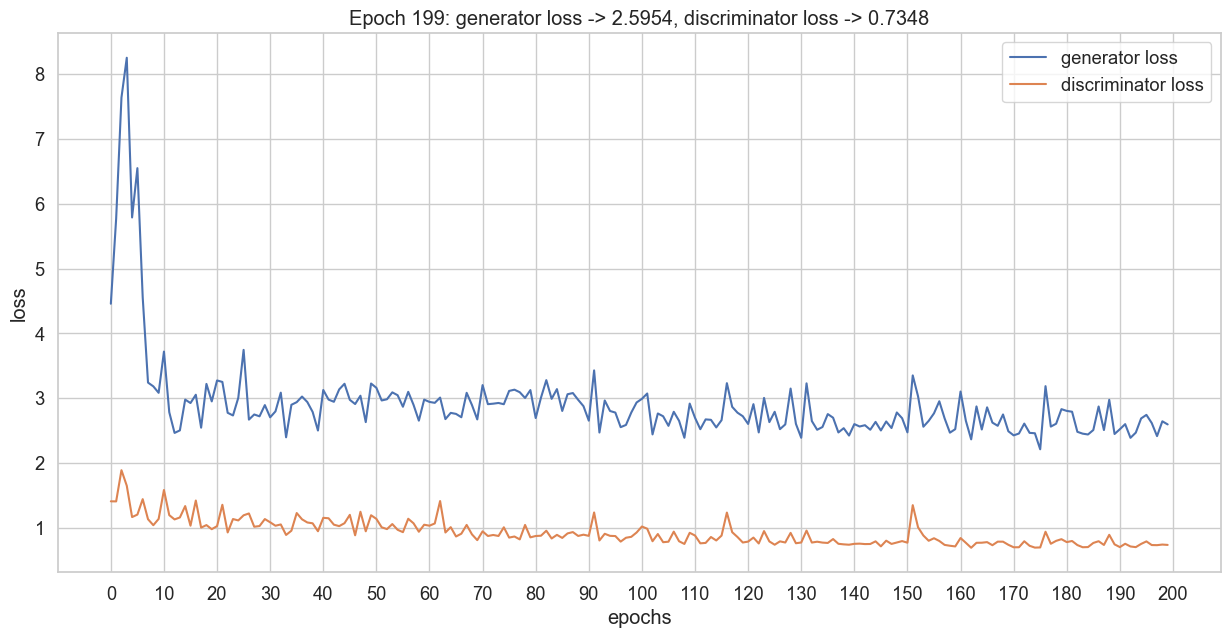

Epoch [200/200], loss_g: 2.5954, loss_d: 0.7348, real_score: 0.8640, fake_score: 0.1309


In [44]:
lr = 0.0002
n_epochs = 200
alpha = 0.2

criterion_discriminator = nn.BCELoss()
criterion_generator = nn.BCELoss()

optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

trainDCGAN = TrainDCGAN(
    n_epochs = n_epochs,
    generator = generator,
    discriminator = discriminator,
    criterion_generator = criterion_generator,
    criterion_discriminator = criterion_discriminator,
    optimizer_generator = optimizer_generator,
    optimizer_discriminator = optimizer_discriminator,
    alpha = alpha)

losses_g, losses_d, real_scores, fake_scores = trainDCGAN.train(dataloader)

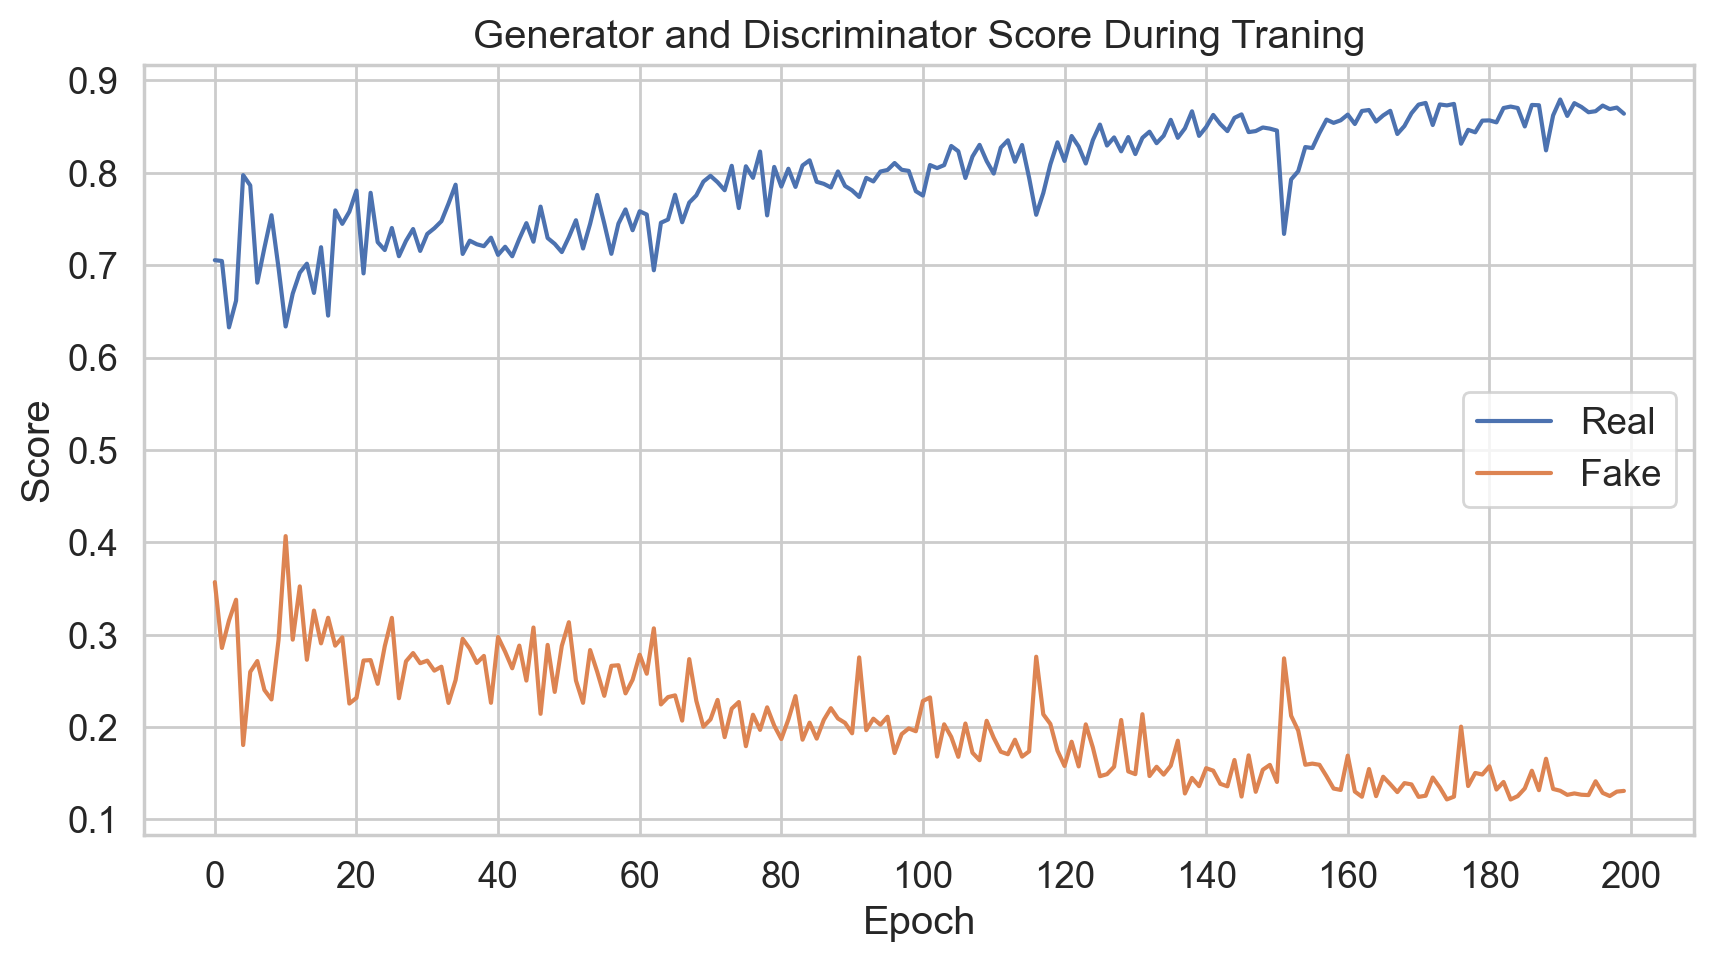

In [45]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=200)

ax.plot(real_scores, label="Real")
ax.plot(fake_scores, label="Fake")
ax.set_xticks(np.arange(0, n_epochs + 1, n_epochs // 10))
ax.set_xlabel("Epoch")
ax.set_ylabel("Score")
ax.set_title("Generator and Discriminator Score During Traning")
ax.legend();

# Генерация изображений 

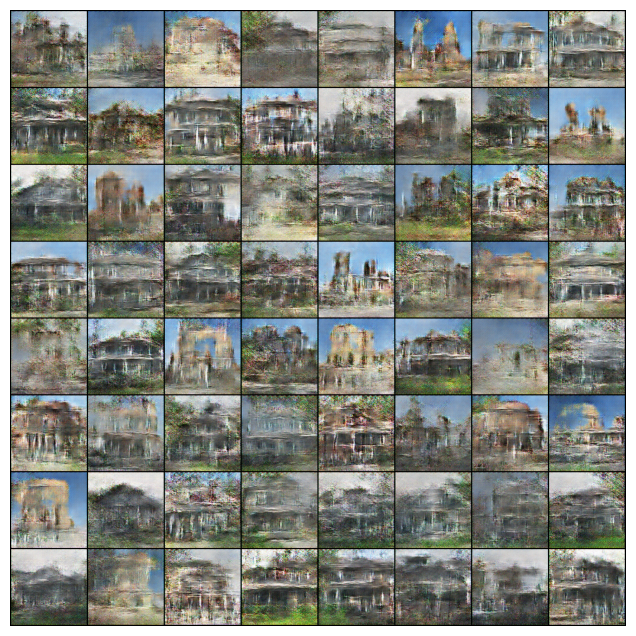

In [46]:
latent = torch.randn(64, latent_size, 1, 1, device=device)
fake_images = generator(latent)

show_images(fake_images, n=64)

## Визуализация распределений

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Воспользуемся методом, снижающим размерность (к примеру, TSNE) и изобразим на графике разным цветом точки, соответствующие реальным и сгенерированным изображениям

In [47]:
n = 500
latent = torch.randn(n, latent_size, 1, 1, device=device)

In [48]:
fake_images = generator(latent)
print(fake_images.shape)

fake_images = fake_images.reshape(fake_images.shape[0], -1)
print(fake_images.shape)

torch.Size([500, 3, 128, 128])
torch.Size([500, 49152])


In [49]:
real_images = []

for i in range(n):
    real_image = dataset[i]
    real_image = real_image.reshape(3 * image_size * image_size, -1)
    real_images.append(real_image)
    
real_images = torch.cat(real_images, dim=1).permute(1, 0)
print(real_images.shape)

torch.Size([500, 49152])


In [50]:
X = torch.cat([real_images.cpu(), fake_images.cpu()]).detach().numpy()
print(X.shape)

y = torch.cat((torch.ones(n), torch.zeros(n))).numpy()
print(y.shape)

(1000, 49152)
(1000,)


In [58]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)
print(X_tsne.shape)

(1000, 2)


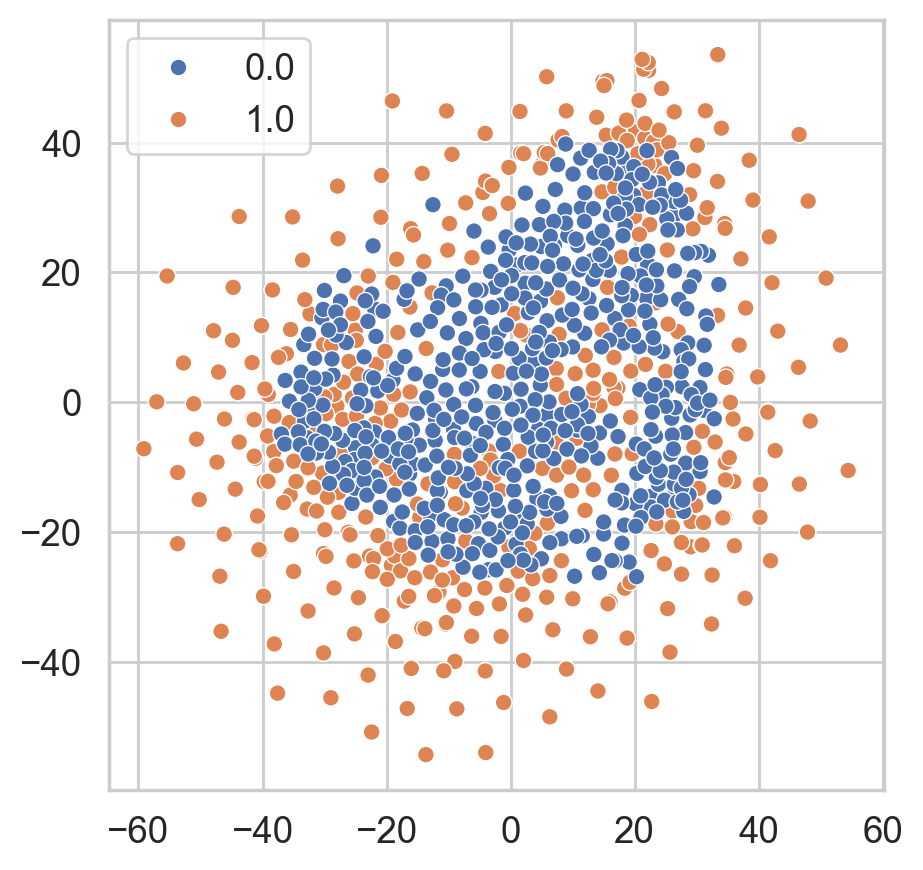

In [59]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=200)
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y);